In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scorecardpy as sc

from category_encoders import WOEEncoder
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

## !pip install scorecardpy --user

In [3]:
## read train and test file respectively. The test file does not have label column
df_train = open("C:/Users/quochung.huynh/Downloads/AAI-TestDS/train_data.txt").read().split() 
df_test  = open("C:/Users/quochung.huynh/Downloads/AAI-TestDS/test_data.txt").read().split()

df_train

['ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86',
 '1,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,0,0,4,3,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0',
 '2,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,2,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0',
 '3,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,0,0,3,4,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0',
 '4,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,0,0,4,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0',
 '5,40,1,4,2,10,1,4,1,4,7,1,2

In [4]:
## Convert df_train to tableau format

## Conver to dataframe
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

## Split into columns seperated by comma
df_train = df_train[0].str.split(',', expand=True) 
df_test = df_test[0].str.split(',', expand=True)

## Indicate first row to be header
df_train = df_train.rename(columns=df_train.iloc[0]).drop(df_train.index[0]) 
df_test = df_test.rename(columns=df_test.iloc[0]).drop(df_test.index[0])

df_train.head()

,ID,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
1,1,33,1,3,2,8,0,5,1,3,...,0,0,0,1,0,0,0,0,0,0
2,2,37,1,2,2,8,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0
3,3,37,1,2,2,8,0,4,2,4,...,0,0,0,1,0,0,0,0,0,0
4,4,9,1,3,3,3,2,3,2,4,...,0,0,0,1,0,0,0,0,0,0
5,5,40,1,4,2,10,1,4,1,4,...,0,0,0,1,0,0,0,0,0,0


In [5]:
df_train.shape

(5822, 87)

In [6]:
#Check if any column contains NaN value besides target column 86
df_train.loc[:, df_train. columns != '86'].isnull().any().any()

False

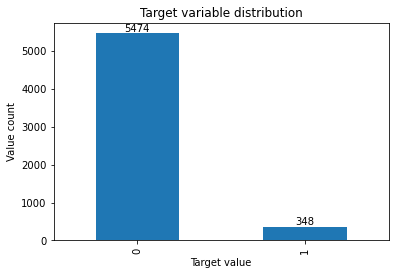

In [7]:
value_counts = df_train['86'].value_counts()

# Plotting bar chart
ax = value_counts.plot(kind="bar")

# Display values
for i, v in enumerate(value_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

# Display labels
plt.xlabel('Target value')
plt.ylabel('Value count')
plt.title('Target variable distribution')
plt.show()


With seen distribution of target variable, this is an imbalanced dataset, a typical case in banking area. I will process the data with widely-used data processing methods and tre-based algo, for its insensitivity with skewed distributed target variable

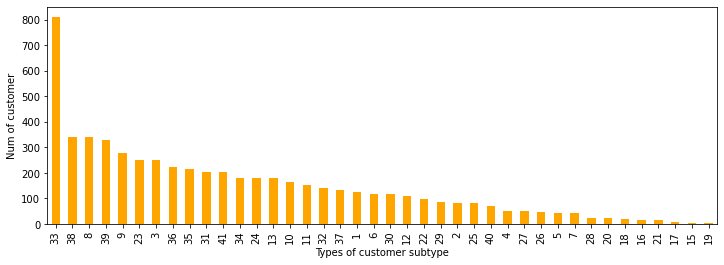

In [8]:
z=df_train['1'].value_counts()

ax = z.plot.bar(figsize=(12,4),color='orange').set(ylabel='Num of customer', xlabel='Types of customer subtype')

plt.show()

A great amount of potential customers are subtype 33 - Lower class large families 

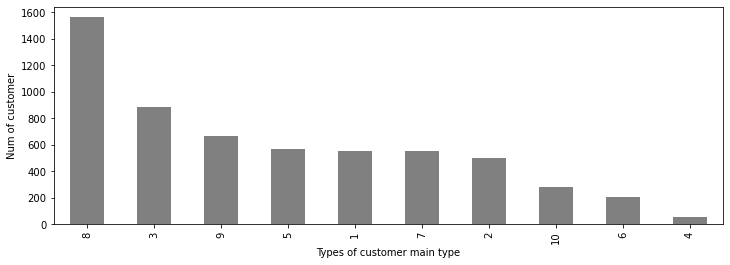

In [9]:
z=df_train['5'].value_counts()

ax = z.plot.bar(figsize=(12,4),color='grey').set(ylabel='Num of customer', xlabel='Types of customer main type')

plt.show()

In [10]:
# Count unique values in the 'Category' column
value_counts = df_train['5'].value_counts()

# Total percentages
percentages = (value_counts / len(df_train)) * 100

# Create a new DataFrame to display results
result_df = pd.DataFrame({'Absolute Count': value_counts, 'Percentage': percentages}).sort_values(by='Percentage', ascending=False)

print(result_df)

    Absolute Count  Percentage
8             1563   26.846445
3              886   15.218138
9              667   11.456544
5              569    9.773274
1              552    9.481278
7              550    9.446925
2              502    8.622467
10             276    4.740639
6              205    3.521127
4               52    0.893164


Most customers are main type 8 - Family with grown ups, following is 3 - Average and 9 - Conservative families

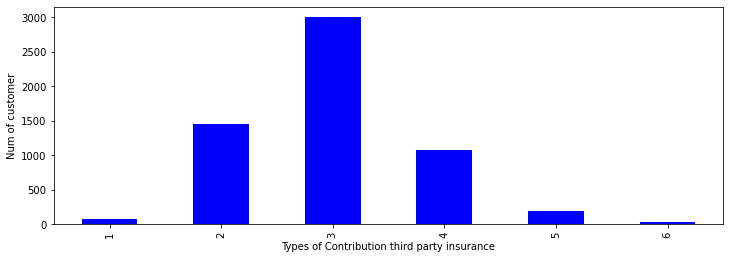

In [11]:
z = df_train['4'].value_counts().sort_index()
z = z.rename(index={1: '20-30', 2: '30-40', 3: '40-50', 4: '50-60', 5: '60-70', 6: '70-80'})

ax = z.plot.bar(figsize=(12, 4), color='blue')
ax.set(ylabel='Num of customer', xlabel='Types of Contribution third party insurance')

plt.show()

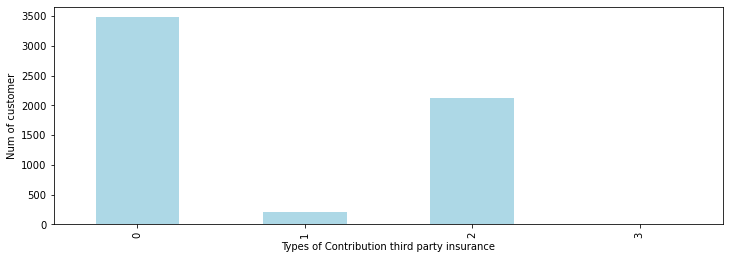

In [12]:
# Plot column 44 - Contribution to third-party insurance with label names
z = df_train['44'].value_counts().sort_index()
z = z.rename(index={0: '0', 1: '1-49', 2: '50-99', 3: '100-199'})

ax = z.plot.bar(figsize=(12, 4), color='lightblue')
ax.set(ylabel='Num of customer', xlabel='Types of Contribution third party insurance')

plt.show()

As from the apendix, we have couples of columns with similar meaning, for example: <br>
      <li><b>Column 44</b> - Contribution private third-party insurance
      <li><b>Column 65</b> - Number of private third-party insurance<br>
          There are 20 pairs of column like this, from column <code>44-64</code> and <code>65-85</code>. Let us see if they will create high correlation with each other

Since the socialdemographic data (attributes 1-42) are derived from zip codes, all customers living in areas with the same zip code have the same social demographic attributes, these variables are consider categorical
To check column multicollinery, I will only check on numeric product ownership columns (43-85)

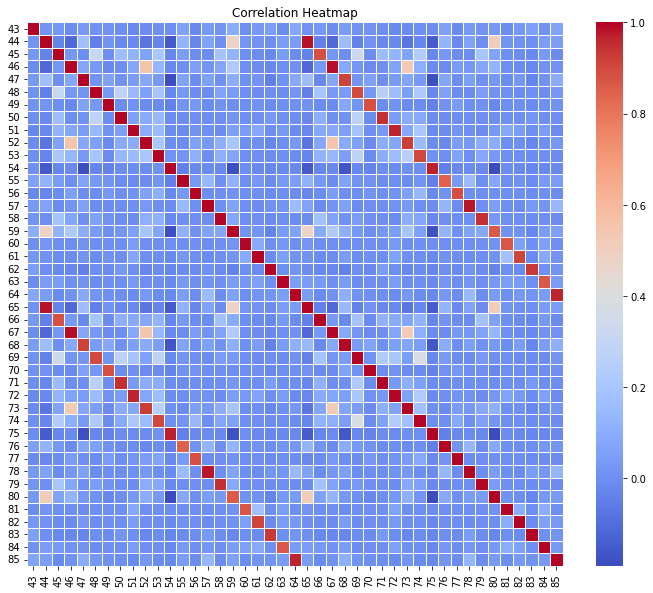

In [13]:
# Split data into train and validation set
x_train, x_val, y_train, y_val = train_test_split(df_train.drop('86', axis=1),df_train['86'], test_size=0.2, random_state=42)


df_corr = x_train.loc[:, x_train.columns.isin(['43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85'])].astype(int)
correlation_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap confirms the theory. Many of these correlated columns have similar meaning, however I do not have a full business context in here, so I will process to drop columns with weaker VIF value.

In [14]:
## Function to calculate variable VIF
def calculate_vif(data_frame):
    ## Calculate Variance Inflation Factor (VIF) for each feature in a DataFrame.
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.select_dtypes(include=[np.number]).values, i) for i in range(data_frame.shape[1])]
    return vif_data.sort_values(by="VIF", ascending=False)

## Calculate variable VIF
vif = calculate_vif(df_corr)
vif[vif['VIF'] > 10]

,Variable,VIF
22,65,46.114592
1,44,45.368973
3,46,40.846234
24,67,40.768969
35,78,25.781870
14,57,25.726901
11,54,18.289737
32,75,18.208211
29,72,14.716390
8,51,14.578625


In [15]:
highly_correlated_pairs = []

# Generate list of highly correlated columns
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.85:
            pair = (correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

highly_correlated_pairs        

[('44', '65', 0.9814058156512403),
 ('45', '66', 0.8853329183692437),
 ('46', '67', 0.9870391197104875),
 ('47', '68', 0.9151131283673576),
 ('48', '69', 0.9000561839032399),
 ('49', '70', 0.8875699106567737),
 ('50', '71', 0.9467909754560802),
 ('51', '72', 0.9635033668739161),
 ('52', '73', 0.9227405672910296),
 ('53', '74', 0.9028660646522537),
 ('54', '75', 0.9701668922916491),
 ('56', '77', 0.8923955865410026),
 ('57', '78', 0.9799411790504549),
 ('58', '79', 0.9451655966183932),
 ('59', '80', 0.8623548331349211),
 ('60', '81', 0.870320280694026),
 ('61', '82', 0.9079978787107886),
 ('62', '83', 0.9338586965642774),
 ('63', '84', 0.8652773791112521),
 ('64', '85', 0.9639505134936864)]

In [16]:
## Remove column that has higher VIF if in correlated list
for pair in highly_correlated_pairs:
    var1, var2, correlation = pair
    
    # Get VIF values 
    vif_var1 = vif[vif['Variable'] == var1]['VIF'].values[0]
    vif_var2 = vif[vif['Variable'] == var2]['VIF'].values[0]
    
    # Remove the higher VIF one
    if vif_var1 > vif_var2:
        x_train.drop(var1, axis=1, inplace=True)
    else:
        x_train.drop(var2, axis=1, inplace=True)
        
## Remove ID column        
x_train = x_train.drop('ID', axis=1)

In [20]:
woe_encoder = WOEEncoder()
x_train_woe = woe_encoder.fit_transform(x_train,y_train.astype(int))

# Calculate Information Value (IV) for each feature
iv_result = sc.iv(
    x_train_woe.assign(target=y_train.astype(int)),
    y='target'
)
# Set a threshold for IV to select features
# IV<0.02 is unpredictive variable
selected_features = iv_result[iv_result['info_value'] >= 0.02]['variable'] 

# Filter the dataset based on selected features
x_train_selected = x_train_woe[selected_features]

<b>Logistic Regression</b>

In [50]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(x_train_selected, y_train.astype(int))

# Check train set performance
y_train_logreg = logreg.predict_proba(x_train_selected)[:, 1]
gini_logreg = 2 * roc_auc_score(y_train, y_train_logreg) - 1
gini_logreg

0.606141810208765

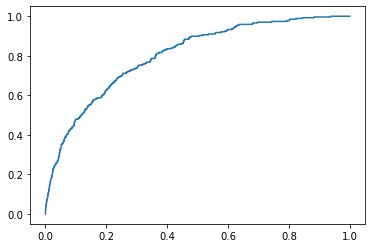

In [51]:
fpr_logreg, tpr_logreg, _ = roc_curve(y_train.astype(int), y_train_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

In [95]:
# Transform and validate validation set
x_val2 = x_val.loc[:, x_val.columns.isin(x_train.columns)]
x_val_woe = woe_encoder.transform(x_val2)
x_val_woe = x_val_woe.loc[:, x_val_woe.columns.isin(x_train_selected.columns)]

y_val_logreg = logreg.predict_proba(x_val_woe)[:, 1]
gini_val_logreg = 2 * roc_auc_score(y_val, y_val_logreg) - 1
gini_val_logreg

0.3102364356976901

In [96]:
# Train with WOE demographic data and numeric product ownership data
# Remove woe encoded product ownership columns
x_train_selected2 = x_train_selected.loc[:, ~x_train_selected.columns.isin(['43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85'])]

# Concat demographic data with numeric product ownership data
x_train_selected2 = pd.concat([x_train_selected2, x_train[[col for col in x_train.columns if col in df_corr.columns]]], axis=1)

In [90]:
# Logistic Regression
logreg2 = LogisticRegression(max_iter=1000)
logreg2.fit(x_train_selected2, y_train.astype(int))

# Check train set performance
y_train_logreg2 = logreg2.predict_proba(x_train_selected2)[:, 1]
gini_logreg2 = 2 * roc_auc_score(y_train, y_train_logreg2) - 1
gini_logreg2

0.599481286205455

In [92]:
# Transform and validate validation set
x_val22 = x_val.loc[:, x_val.columns.isin(x_train.columns)]
x_val_woe2 = woe_encoder.transform(x_val22)
x_val_woe2 = x_val_woe2.loc[:, x_val_woe2.columns.isin(x_train_selected2.columns)]

y_val_logreg2 = logreg2.predict_proba(x_val_woe2)[:, 1]
gini_val_logreg2 = 2 * roc_auc_score(y_val, y_val_logreg2) - 1
gini_val_logreg2

0.43541296524076345

<b>Random Forest</b>

In [54]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_selected, y_train.astype(int))

# Check train set performance
y_train_rf = rf.predict_proba(x_train_selected)[:, 1]
gini_rf = 2 * roc_auc_score(y_train, y_train_rf) - 1
gini_rf

0.9965891155417914

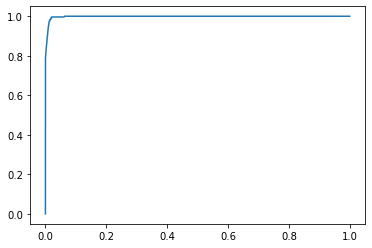

In [97]:
fpr_rf, tpr_rf, _ = roc_curve(y_train.astype(int), y_train_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

In [59]:
# Check validation set performance
y_val_rf = rf.predict_proba(x_val_woe)[:, 1]
gini_val_rf = 2 * roc_auc_score(y_val, y_val_rf) - 1
gini_val_rf

0.36944786114527783

In [98]:
# Random Forest on x_train_selected2 set
rf2 = RandomForestClassifier()
rf2.fit(x_train_selected2, y_train.astype(int))

# Check train set performance
y_train_rf2 = rf2.predict_proba(x_train_selected2)[:, 1]
gini_rf2 = 2 * roc_auc_score(y_train, y_train_rf2) - 1
gini_rf2

0.9969730320015697

<b> XG Boost </b>

In [93]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train_selected, y_train.astype(int))

# Check train set performance
y_train_xgb = xgb.predict_proba(x_train_selected)[:, 1]
gini_xgb = 2 * roc_auc_score(y_train, y_train_xgb) - 1
gini_xgb

0.9938044414868656

In [ ]:
# Check validation set performance
y_val_xgb = xgb.predict_proba(x_val_woe)[:, 1]
gini_val_xgb = 2 * roc_auc_score(y_val, y_val_xgb) - 1
gini_val_xgb

In [75]:
def calculate_gini_and_roc(y_true, y_proba, set_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    gini = 2 * roc_auc - 1
    return gini, roc_auc

# Hyperparameter tuning using GridSearchCV (Gradient Descent)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]

}

# Logistic Regression Tuning
grid_logreg = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=5)
grid_logreg.fit(x_train_selected, y_train.astype(int))
best_logreg = grid_logreg.best_estimator_
y_train_proba_best_logreg = best_logreg.predict_proba(x_train_selected)[:, 1]
y_val_proba_best_logreg = best_logreg.predict_proba(x_val_woe)[:, 1]
gini_best_logreg, roc_best_logreg = calculate_gini_and_roc(y_val.astype(int), y_val_proba_best_logreg, "Tuned Logistic Regression")


C:\Users\quochung.huynh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\quochung.huynh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [76]:
param_grid = {
    'max_depth': [5, 10, 20, 30],
    'criterion' :['gini', 'entropy']

}
# Random Forest Tuning
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='roc_auc', cv=5)
grid_rf.fit(x_train_selected, y_train.astype(int))
best_rf = grid_rf.best_estimator_
y_val_proba_best_rf = best_rf.predict_proba(x_val_woe)[:, 1]
gini_best_rf = 2 * roc_auc_score(y_val.astype(int), y_val_proba_best_rf) - 1

In [73]:
gini_best_rf

0.3386747756366453

<b>{</br>
    to be continued: apply cross-validation, </br>
                  binning on column <code>1</code> for it having too many variables, </br>
                  tuning with gridsearchCV </br>
}